# 1D regression showdown

In [121]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [117]:
import test_lofi
import test_diag_ekf

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [142]:
train, test = datasets.load_1d_synthetic_dataset(5_000, 1000, sort_data=False)

(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

In [143]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean()
    }
    return res

## Test setup

In [144]:
key = jax.random.PRNGKey(27182)

In [168]:
n_warmup = 1000

X_warmup = X_train[:n_warmup]
y_warmup = y_train[:n_warmup]

X_learn = X_train[n_warmup:]
y_learn = y_train[n_warmup:]

warmup_train = (X_warmup[:-100], y_warmup[:-100])
warmup_test = (X_warmup[-100:], y_warmup[-100:])

In [146]:
pbounds = {
    "log_init_cov": (-5, 1.1),
    "dynamics_weights": (0, 1),
    "log_emission_cov": (-7, -1e-6),
    "log_dynamics_cov": (-7, -1e-6),
}


## Model setup

In [147]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
dim_out = 1
_, dim_in = X_train.shape
model = MLP(dim_out, activation=nn.elu)

# Agent showdown

## Diag-EKF

In [148]:
optimizer, apply_fn, n_params = test_diag_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback
)

In [149]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.016    | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -1.072    | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8563   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.8163   | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.9      | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -1.017    | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -0.829    | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.8155   | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -0.9962   | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.819    | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.815    | 0.0       | -6.886    | -1e-06    | -1.224    |
| 12        | -0.815    | 0.0       | 

In [150]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)

n_params = len(flat_params)
hparams = test_diag_ekf.get_best_params(n_params, optimizer)
params_rebayes = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)

test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
dekf_estimator = ekf.RebayesEKF(params_rebayes, method="fdekf")
bel_dekf, output_dekf = dekf_estimator.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## LoFi

In [151]:
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)

optimizer, apply_fn, n_params = test_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback
)

In [152]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.127    | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -0.8646   | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8184   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.8207   | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.9553   | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -0.9973   | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -1.0      | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.99     | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -0.9999   | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.8406   | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.4363   | 1.0       | -7.0      | -1e-06    | -5.0      |
| 12        | -0.8151   | 0.0       | 

In [159]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)
hparams = test_lofi.get_best_params(n_params, optimizer)
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

lofi_estimator = test_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn)
bel_lofi, output_lofi = lofi_estimator.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

## LoFi-aov

In [221]:
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0
)

optimizer, apply_fn, n_params = test_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method="aov_lofi"
)

In [222]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.009    | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -0.8186   | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8158   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.816    | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.8276   | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -0.8177   | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -0.96     | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.878    | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -0.8186   | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.819    | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.8152   | 0.0       | -4.283    | -4.006    | -4.414    |
| 12        | -0.8151   | 0.0       | 

In [223]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)
hparams = test_lofi.get_best_params(n_params, optimizer)
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

lofi_aov_estimator = test_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method="aov_lofi")
bel_lofi_aov, output_lofi_aov = lofi_aov_estimator.scan(
    X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs
)

## FC-EKF

In [261]:
optimizer, apply_fn, n_params = test_diag_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fcekf"
)

In [262]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -1.21     | 0.9169    | -2.88     | -5.145    | -0.2224   |
| 2         | -1.043    | 0.918     | -1.209    | -1.904    | -3.411    |
| 3         | -0.8563   | 0.9118    | -5.175    | -1.635    | -3.405    |
| 4         | -0.8163   | 0.1223    | -4.298    | -1.119    | -3.303    |
| 5         | -0.9      | 0.06991   | -2.568    | -2.907    | -1.454    |
| 6         | -1.017    | 0.6772    | -2.19     | -3.928    | -3.042    |
| 7         | -0.829    | 0.5706    | -3.641    | -0.9725   | 0.09231   |
| 8         | -0.8155   | 0.1058    | -6.577    | -2.822    | -0.1664   |
| 9         | -0.9962   | 0.2264    | -3.254    | -6.048    | -2.729    |
| 10        | -0.819    | 0.152     | -3.991    | -1.451    | -2.518    |
| 11        | -0.815    | 0.0       | -6.562    | -1e-06    | -1.021    |
| 12        | -0.3372   | 1.0       | 

In [264]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)

n_params = len(flat_params)
hparams = test_diag_ekf.get_best_params(n_params, optimizer, method="fcekf")
params_rebayes = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)

test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}
fcekf_estimator = ekf.RebayesEKF(params_rebayes, method="fcekf")
bel_fcekf, output_fcekf = fcekf_estimator.scan(
    X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs
)

## ORFit

In [212]:
params_orfit = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)
estimator_orfit = lofi.RebayesLoFi(params_orfit, params_lofi, method='orfit')
bel_orfit, output_orfit = estimator_orfit.scan(X_learn, y_learn, callback=rmae_callback, progress_bar=False, **test_kwargs)

In [215]:
@partial(jax.pmap, in_axes=1)
@partial(jax.vmap, in_axes=0)
def evalf(key):
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, _ = ravel_pytree(params)
    n_params = len(flat_params)
    
    estimator = lofi.RebayesLoFi(params_orfit, params_lofi, method='orfit')
    
    # hparams = test_diag_ekf.get_best_params(n_params, optimizer)
    # estimator = test_diag_ekf.build_estimator(flat_params, hparams, params_lofi, apply_fn)
    
    n_vals = len(X_learn)
    ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
    bel, output = estimator.scan(X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=rmae_callback, progress_bar=False, **test_kwargs)
    return output["test"]
    
keys = jax.random.split(key, 8 * 5).reshape(-1, 8, 2)
outputs = evalf(keys).reshape(40, -1)
data_orfit = pd.DataFrame(outputs).T

## Plot results

In [267]:
data = {
    "orfit": np.array(output_orfit["test"]),
    "lofi": np.array(output_lofi["test"]),
    "lofi-aov": np.array(output_lofi_aov["test"]),
    "dekf": np.array(output_dekf["test"]),
    "fcekf": np.array(output_fcekf["test"])
}

data = pd.DataFrame(data)

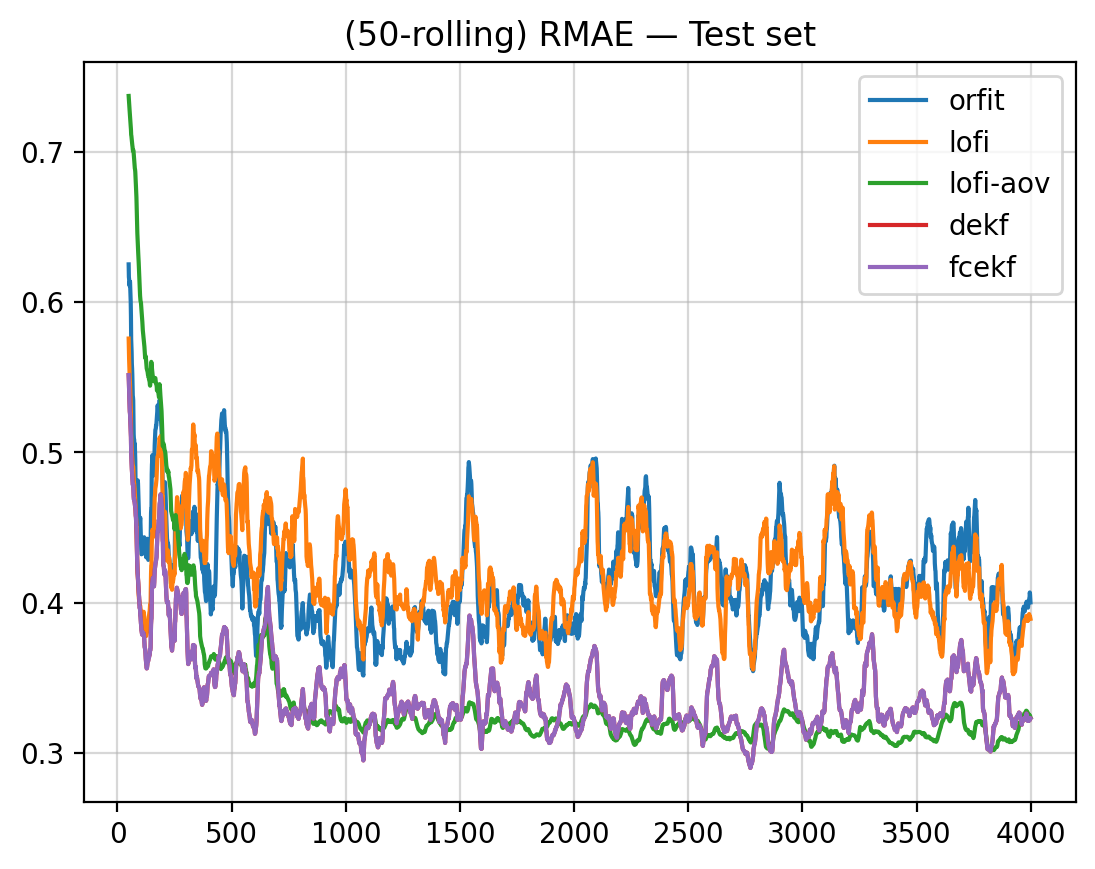

In [268]:
data.rolling(50).mean().plot()
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

In [162]:
params_rebayes = base.RebayesParams(
    initial_mean=None,
    emission_mean_function=apply_fn,
    **hparams
)

In [266]:
@partial(jax.pmap, in_axes=1)
@partial(jax.vmap, in_axes=0)
def evalf(key):
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, _ = ravel_pytree(params)
    n_params = len(flat_params)
    
    # hparams = test_lofi.get_best_params(n_params, optimizer)
    # estimator = test_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn)
    
    # hparams = test_diag_ekf.get_best_params(n_params, optimizer)
    # estimator = test_diag_ekf.build_estimator(flat_params, hparams, params_lofi, apply_fn)
    
    # hparams = test_lofi.get_best_params(n_params, optimizer)
    # estimator = test_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method="aov_lofi")
    
    hparams = test_diag_ekf.get_best_params(n_params, optimizer, method="fcekf")
    estimator = test_diag_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fcekf")
    
    n_vals = len(X_learn)
    ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
    bel, output = estimator.scan(X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=rmae_callback, progress_bar=False, **test_kwargs)
    return output["test"]
    
keys = jax.random.split(key, 8 * 5).reshape(-1, 8, 2)
outputs = evalf(keys).reshape(40, -1)
data_aov_lofi = pd.DataFrame(outputs).T

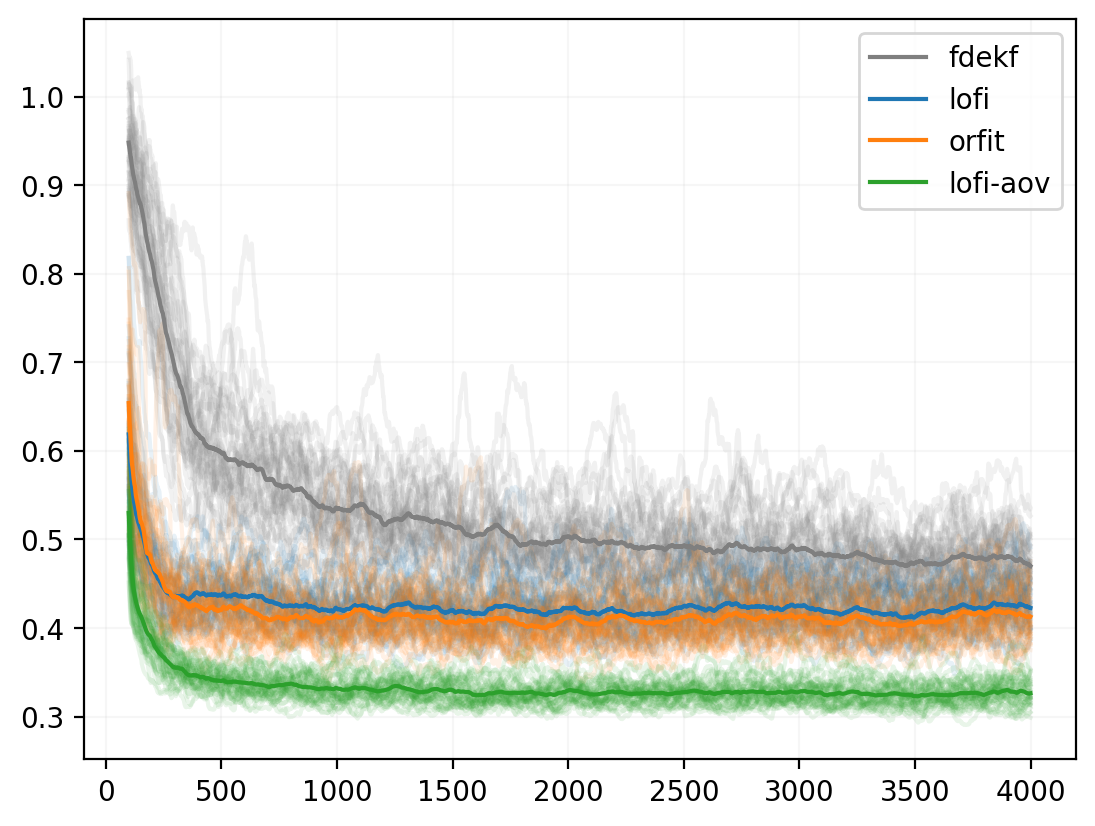

In [269]:
fig, ax = plt.subplots()

data_diag_ekf.mean(axis=1).rolling(100).mean().plot(c="tab:gray", ax=ax, label="fdekf")
data_lofi.mean(axis=1).rolling(100).mean().plot(c="tab:blue", ax=ax, label="lofi")
data_orfit.mean(axis=1).rolling(100).mean().plot(c="tab:orange", ax=ax, label="orfit")
data_aov_lofi.mean(axis=1).rolling(100).mean().plot(c="tab:green", ax=ax, label="lofi-aov")

plt.legend()

data_diag_ekf.rolling(100).mean().plot(c="tab:gray", alpha=0.1, ax=ax, legend=False, zorder=0)
data_lofi.rolling(100).mean().plot(c="tab:blue", alpha=0.1, ax=ax, legend=False, zorder=0)
data_orfit.rolling(100).mean().plot(c="tab:orange", alpha=0.1, ax=ax, legend=False, zorder=0)
data_aov_lofi.rolling(100).mean().plot(c="tab:green", alpha=0.1, ax=ax, legend=False, zorder=0)

plt.grid(alpha=0.1)